# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tobias Schulze

**Date:** 14 September 2023



## Loading of required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Importing the data

In [2]:
df = pd.read_csv('./data/230907_basic_table_for_analysis_cleaned.csv', low_memory = False, index_col = 0)

## Data description
### Data

In [3]:
df.head()

,num_veh,place,catu,grav,sexe,an_nais,trajet,locp,actp,etatp,...,obs,obsm,choc,manv,date,is_holiday,holiday,secu_used,secu_avail,fatal
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,B01,2.0,2,4,2,2002.0,0.0,-1.0,-1,-1.0,...,0.0,2.0,5.0,23.0,2019-11-30,False,NaN,3,1,0
201900000001,B01,1.0,1,4,2,1993.0,5.0,-1.0,-1,-1.0,...,0.0,2.0,5.0,23.0,2019-11-30,False,NaN,3,1,0
201900000001,A01,1.0,1,1,1,1959.0,0.0,-1.0,-1,-1.0,...,1.0,0.0,3.0,11.0,2019-11-30,False,NaN,3,1,0
201900000002,A01,1.0,1,4,2,1994.0,0.0,-1.0,-1,-1.0,...,4.0,0.0,1.0,0.0,2019-11-30,False,NaN,3,1,0
201900000003,A01,1.0,1,1,1,1996.0,0.0,-1.0,0,-1.0,...,0.0,2.0,1.0,2.0,2019-11-28,False,NaN,3,1,0


### Data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509596 entries, 201900000001 to 201800057783
Data columns (total 46 columns):
 #   Column        Dtype  
---  ------        -----  
 0   num_veh       object 
 1   place         float64
 2   catu          int64  
 3   grav          int64  
 4   sexe          int64  
 5   an_nais       float64
 6   trajet        float64
 7   locp          float64
 8   actp          object 
 9   etatp         float64
 10  an            int64  
 11  mois          int64  
 12  jour          int64  
 13  hrmn          object 
 14  lum           int64  
 15  agg           int64  
 16  int           int64  
 17  atm           float64
 18  col           float64
 19  adr           object 
 20  lat           float64
 21  long          float64
 22  dep           int64  
 23  metropolitan  float64
 24  catr          float64
 25  circ          float64
 26  nbv           float64
 27  vosp          float64
 28  prof          float64
 29  plan          float64
 30  surf   

### Missing data

In [5]:
df.isna().sum()

num_veh               0
place                 0
catu                  0
grav                  0
sexe                  0
an_nais               0
trajet                0
locp                  0
actp                  0
etatp                 0
an                    0
mois                  0
jour                  0
hrmn                  0
lum                   0
agg                   0
int                   0
atm                   0
col                   0
adr              343702
lat             1065871
long            1073114
dep                   0
metropolitan          0
catr                  0
circ                  0
nbv                   0
vosp                  0
prof                  0
plan                  0
surf                  0
infra                 0
situ                  0
senc                  0
catv                  0
occutc                0
obs                   0
obsm                  0
choc                  0
manv                  0
date                  0
is_holiday      

## Data preparation
### Transform data types
#### Date and time variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

For the grouping, a timestamp is required for unbiased identification time related accidents.

_Problem_:

During the transformation of the `hrmn` variable, I got aware, that the string contain integers like `1`,  `801`, or `1300`. Hence, anytime during data conversion, the colon got lost and the values got truncated. Hence `1` should be `00:01` and so on. Therefore, we need an additional transformation of the truncated data to `h:m` format.

**Steps:**
1. Fixing the truncated values in `hrmn`
3. Creation of a `datatime` variable in format y-m-d hh:mm
4. Transformation of the datatime varible to a `timestamp` variable


In addition, we need to transform the type of `an_nais` to integer and `date` to `date`.

In [6]:
# Fixing the hrmn issue:
# Remove the colon
df['hrmn'] = df.apply(lambda x: re.sub(string=x['hrmn'], pattern=':', repl=''), axis = 1)

# Pad the string to four zeros
df['hrmn'] = df.apply(lambda x: x['hrmn'].zfill(4), axis = 1)

# Transform the variable to 'hh:mm' and split to hours and minutes
df = df.assign(hrmn = pd.to_datetime(df['hrmn'], format='%H%M').dt.strftime('%H:%M'))

# Create the daytime variable
df['datetime'] = df.apply(lambda x: datetime(x['an'], x['mois'], x['jour'], datetime.strptime(x['hrmn'], "%H:%M").hour, datetime.strptime(x['hrmn'], "%H:%M").minute), axis = 1)

# Create the timestamp
df['timestamp'] = df.apply(lambda x: datetime.timestamp(x['datetime']), axis = 1)

# Transform `an_nais`
df['an_nais'] = df['an_nais'].astype('int64')

# Transform `date`
df = df.assign(date = pd.to_datetime(df['date'], format='mixed'))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509596 entries, 201900000001 to 201800057783
Data columns (total 48 columns):
 #   Column        Dtype         
---  ------        -----         
 0   num_veh       object        
 1   place         float64       
 2   catu          int64         
 3   grav          int64         
 4   sexe          int64         
 5   an_nais       int64         
 6   trajet        float64       
 7   locp          float64       
 8   actp          object        
 9   etatp         float64       
 10  an            int64         
 11  mois          int64         
 12  jour          int64         
 13  hrmn          object        
 14  lum           int64         
 15  agg           int64         
 16  int           int64         
 17  atm           float64       
 18  col           float64       
 19  adr           object        
 20  lat           float64       
 21  long          float64       
 22  dep           int64         
 23  metropolitan  float64

### Drop variables
The dataset still contains variables with missing values. Some of them are important for possible mapping or a fine granulated classification.

- `adr`: The address variable has missing values and is very fuzzy, so encoding might not be successfully.

- `lat` and `lat`: not available for all sites

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant

- `grav`: granulated classification of the target `fatal`

- `datetime`: encoded in `timestamp`

- `date`: encoded in separate datatime variables

- `timestamp`: same as `date`

- `etatp`: strongly correlate with `actp` and fine granulation

In [8]:
df_bak = df

In [9]:
#df_bak = df

columns_drop = ['adr', 'lat', 'long', 'holiday', 'grav', 'datetime', 'date', 'timestamp', 'etatp']

df.drop(columns = columns_drop, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509596 entries, 201900000001 to 201800057783
Data columns (total 39 columns):
 #   Column        Dtype  
---  ------        -----  
 0   num_veh       object 
 1   place         float64
 2   catu          int64  
 3   sexe          int64  
 4   an_nais       int64  
 5   trajet        float64
 6   locp          float64
 7   actp          object 
 8   an            int64  
 9   mois          int64  
 10  jour          int64  
 11  hrmn          object 
 12  lum           int64  
 13  agg           int64  
 14  int           int64  
 15  atm           float64
 16  col           float64
 17  dep           int64  
 18  metropolitan  float64
 19  catr          float64
 20  circ          float64
 21  nbv           float64
 22  vosp          float64
 23  prof          float64
 24  plan          float64
 25  surf          float64
 26  infra         float64
 27  situ          float64
 28  senc          float64
 29  catv          int64  
 30  occutc 

### Encoding
For the first trial, use the `LabelEncoder` to encode categorial values. Then drop the old categorial values and replace them by the encoded.

In [11]:
# Encoding with LabelEncoder
encode_columns = ['actp', 'num_veh', 'hrmn']
encoded_df = df[encode_columns]
encoded_df = encoded_df.astype('str')
encoded_df = encoded_df.apply(LabelEncoder().fit_transform)

# Merge encoded values
df_encoded = df
df_encoded.drop(encode_columns, inplace=True, axis=1)
df_encoded = pd.concat([encoded_df, df_encoded], axis=1)


### Filtering
It was decided to use only accidents in metropolitan France and Corse.

In preprocessing, the varible `metropolitan` with values `[0,1]` was created.

Now, the data is fitered by this variable and then it is dropped.

In [12]:
df_encoded = df_encoded.loc[df_encoded['metropolitan'] == 1]
df_encoded.drop('metropolitan', inplace=True, axis=1)

In [13]:
df_encoded.isna().sum()

actp          0
num_veh       0
hrmn          0
place         0
catu          0
sexe          0
an_nais       0
trajet        0
locp          0
an            0
mois          0
jour          0
lum           0
agg           0
int           0
atm           0
col           0
dep           0
catr          0
circ          0
nbv           0
vosp          0
prof          0
plan          0
surf          0
infra         0
situ          0
senc          0
catv          0
occutc        0
obs           0
obsm          0
choc          0
manv          0
is_holiday    0
secu_used     0
secu_avail    0
fatal         0
dtype: int64

In [14]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421738 entries, 201900000001 to 201800055766
Data columns (total 38 columns):
 #   Column      Dtype  
---  ------      -----  
 0   actp        int64  
 1   num_veh     int64  
 2   hrmn        int64  
 3   place       float64
 4   catu        int64  
 5   sexe        int64  
 6   an_nais     int64  
 7   trajet      float64
 8   locp        float64
 9   an          int64  
 10  mois        int64  
 11  jour        int64  
 12  lum         int64  
 13  agg         int64  
 14  int         int64  
 15  atm         float64
 16  col         float64
 17  dep         int64  
 18  catr        float64
 19  circ        float64
 20  nbv         float64
 21  vosp        float64
 22  prof        float64
 23  plan        float64
 24  surf        float64
 25  infra       float64
 26  situ        float64
 27  senc        float64
 28  catv        int64  
 29  occutc      float64
 30  obs         float64
 31  obsm        float64
 32  choc        float64
 

#### Marking categorial data
XGboost enables the use of specific categorial data. Hence, the change of the type to `categorial` is required[3].

In [15]:
cat_columns = ['actp', 'num_veh', 'hrmn', 'place', 'catu', 'sexe', 'trajet',
       'locp', 'lum', 'agg', 'int', 'atm', 'col', 'dep',
       'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ',
       'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv',
       'secu_used', 'secu_avail', 'fatal', 'is_holiday']
cat_df = df_encoded[cat_columns]
cat_df = cat_df.astype('category')

# Merge new type columns
df_encoded.drop(cat_columns, inplace=True, axis=1)
df_encoded = pd.concat([df_encoded, cat_df], axis=1)


In [16]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421738 entries, 201900000001 to 201800055766
Data columns (total 38 columns):
 #   Column      Dtype   
---  ------      -----   
 0   an_nais     int64   
 1   an          int64   
 2   mois        int64   
 3   jour        int64   
 4   actp        category
 5   num_veh     category
 6   hrmn        category
 7   place       category
 8   catu        category
 9   sexe        category
 10  trajet      category
 11  locp        category
 12  lum         category
 13  agg         category
 14  int         category
 15  atm         category
 16  col         category
 17  dep         category
 18  catr        category
 19  circ        category
 20  nbv         category
 21  vosp        category
 22  prof        category
 23  plan        category
 24  surf        category
 25  infra       category
 26  situ        category
 27  senc        category
 28  catv        category
 29  occutc      category
 30  obs         category
 31  obsm        c

In [17]:
df_encoded['is_holiday'].unique()

[False, True]
Categories (2, bool): [False, True]

## Data analysis
### Correlation matrix
To get a first glimpse on the possible contrains in the data, a correlation matrix is plotted.

The data variables are dropped to remove redundany with `timestamp`.

In [18]:
# Drop date columns for the correlation matrix
columns_drop = ['an', 'mois', 'jour']
df_select = df_encoded.drop(columns_drop, axis = 1)

In [19]:
# Scale the data
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_select), columns=df_select.columns)

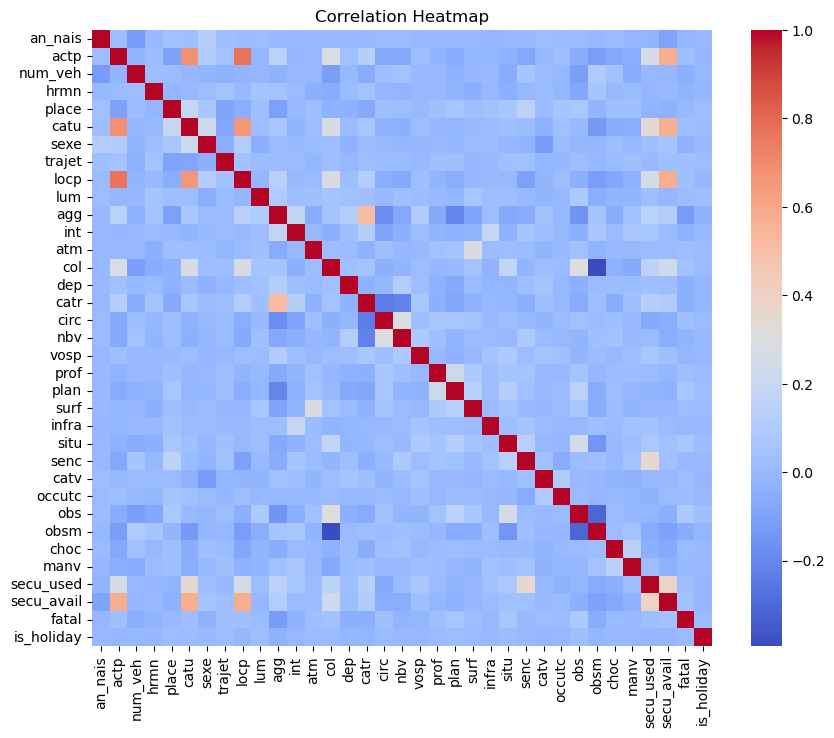

In [20]:
# Create a correlation matrix
correlation_matrix = df_numeric_scaled.corr()
plt.figure(figsize=(10, 8))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show();

The correlation matrix shows some intervariable correlations, but no real importance of variables to predict the target `fatal`. 

### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. The years 2005 to 2019 are selected for the train dataset and the years 2020 and 2021 for the test dataset.

~In addition, the test dataset is split to a train and evaluation dataset with an evaluation set of 20% of the testing data.~

In [21]:
# split the dataset to train and test data
X_train = df_encoded.loc[df_encoded['an'] < 2020].drop('fatal', axis = 1)
X_test = df_encoded.loc[df_encoded['an'] > 2019].drop('fatal', axis = 1)

y_train = df_encoded['fatal'].loc[df_encoded['an'] < 2020]
y_test = df_encoded['fatal'].loc[df_encoded['an'] > 2019]

#split the train dataset to train and eval data
#X_test, X_eval, y_test, y_eval = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

#### Data scaling
Decision trees are not sensitive to different scales and thus scaling is not required.

#### Create xgboost matrices
xgboost requires a specific matrix format. Depends on the training method.

### Modelling the data using a XGBoost Classification Model with Tree-based Parzen Estimators optimisation
The Tree-based Parzen Estimator (TPE) [1] optimisation combines a Bayesian Sequential Model Based Optimisation (SMBO) and a random search on the hyperparemeter grid[2]. While the random search is a static approach, the SMBO optimises the model using prior runs to determine future points of exploration.

The package `hyperopt` [4] is used for optimisation. The hyperparameter optimisation code is written based on ideas in [5].

#### The tuning space
`hyperopt` uses a specific format of parameters expressions [7]. Hints on the parameter ranges are given in [1,5,7].

The `booster` in this first model is `gbtree`. The evaluation metric is `logloss` or `auc`[8].

In a later state, also Dropouts meet Multiple Additive Regression Trees (`dart`)[9] is tested.


In [22]:
# Create the tuning space
booster = 'gbtree'
eval_metric = 'auc'

tuning_space={
    'eta': hp.uniform('eta', 0, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform ('gamma', 0, 10),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 100),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0, 1),
    'colsample_bynode' : hp.uniform('colsample_bynode', 0, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
    'seed': 123,
    'early_stopping_rounds': 10,
    'objective': 'binary:logistic',
    'subsample': hp.uniform('subsample', 0, 1)
    }

if (eval_metric == 'auc') or (eval_metric == 'logloss'):
    tuning_space.update({'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 2)}) # helps in auc
    tuning_space.update({'max_delta_step': hp.uniform('max_delta_step', 0, 2)}) # helps in auc
    tuning_space.update({'eval_metric': eval_metric})
    tuning_space.update({'booster': booster})

if (booster == 'dart'):
    tuning_space.update({'rate_drop': hp.uniform('rate_drop', 0, 1)})
    tuning_space.update({'one_drop': 0})
    tuning_space.update({'skip_drop': hp.uniform('skip_drop', 0, 1)})

tuning_space

{'eta': <hyperopt.pyll.base.Apply at 0x7f277e808190>,
 'max_depth': <hyperopt.pyll.base.Apply at 0x7f277e808750>,
 'gamma': <hyperopt.pyll.base.Apply at 0x7f277e808bd0>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x7f277e809050>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x7f277e8094d0>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7f277e809950>,
 'colsample_bylevel': <hyperopt.pyll.base.Apply at 0x7f277e809dd0>,
 'colsample_bynode': <hyperopt.pyll.base.Apply at 0x7f277e80a250>,
 'min_child_weight': <hyperopt.pyll.base.Apply at 0x7f277e80a790>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x7f277e80acd0>,
 'seed': 123,
 'early_stopping_rounds': 10,
 'objective': 'binary:logistic',
 'subsample': <hyperopt.pyll.base.Apply at 0x7f277e80b150>,
 'scale_pos_weight': <hyperopt.pyll.base.Apply at 0x7f277e80b5d0>,
 'max_delta_step': <hyperopt.pyll.base.Apply at 0x7f277e80ba90>,
 'eval_metric': 'auc',
 'booster': 'gbtree'}

#### The tuning function

In [23]:
# Function for the classification
def hp_xgbclass(space, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    """ Function for Bayesian hyperparameter optimisation of XGboost classification model.
    Accepts a parameter `space` and the training and testing data set.
        :param tuning_space: a catalog containing the parameters used for hyperparameter tuning, ranges given in hp objects
        :param X_train: accepts the train data
        :param X_test: accepts the test data
        :param X_eval: accepts the eval data used for optimisation
        :param y_train: accepts the train target
        :param y_test: accepts the test target
        :param y_eval: accepts the eval data used for optimisation
    """

    if (space['objective'] == 'binary:logistic') and (space['booster'] == 'gbtree'):
        clf=xgb.XGBClassifier(
            eta = space['eta'],
            eval_metric = space['eval_metric'],
            booster = space['booster'],
            n_estimators = np.int64(space['n_estimators']),
            max_depth = np.int64(space['max_depth']),
            gamma = space['gamma'],
            reg_alpha = space['reg_alpha'],
            min_child_weight=np.int64(space['min_child_weight']),
            colsample_bytree=space['colsample_bytree'],
            colsample_bylevel=space['colsample_bylevel'],
            colsample_bynode=space['colsample_bynode'],
            early_stopping_rounds = space['early_stopping_rounds'],
            objective = space['objective'],
            scale_pos_weight = space['scale_pos_weight'],
            max_delta_step = space['max_delta_step'],
            subsample = space['subsample'],
            enable_categorical = True
        )
            

    if (space['objective'] == 'binary:logistic') and (space['booster'] == 'dart'):
        clf=xgb.XGBClassifier(
            eta = space['eta'],
            eval_metric = space['eval_metric'],
            booster = space['booster'],
            n_estimators = np.int64(space['n_estimators']),
            max_depth = np.int64(space['max_depth']),
            gamma = space['gamma'],
            reg_alpha = space['reg_alpha'],
            min_child_weight=np.int64(space['min_child_weight']),
            colsample_bytree=space['colsample_bytree'],
            colsample_bylevel=space['colsample_bylevel'],
            colsample_bynode=space['colsample_bynode'],
            early_stopping_rounds = space['early_stopping_rounds'],
            objective = space['objective'],
            scale_pos_weight = space['scale_pos_weight'],
            max_delta_step = space['max_delta_step'],
            subsample = space['subsample'],
            rate_drop = space['rate_drop'],
            one_drop = space['one_drop'],
            skip_drop = space['skip_drop'],
            enable_categorical = True
        )
    

    clf.fit(X_train,
            y_train,
            eval_set = [(X_test, y_test)],
            verbose=False)
        
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [31]:
# Running the crossvalidation or load stored parameters

# Rerun or get stored parameters
cv_rerun = False

# define the stored files
# gbtree
if (tuning_space['eval_metric'] == 'auc') and (tuning_space['booster'] == 'gbtree'):
    out_file_trial = './data/XGboost_model/160923_XGboost_gbtree_auc_trial_db'
    out_file_params = './data/XGboost_model/160923_XGboost_gbtree_auc_hyperparameters'
    
elif (tuning_space['eval_metric'] == 'lossless') and (tuning_space['booster'] == 'gbtree'):
    out_file_trial = './data/XGboost_model/160923_XGboost_gbtree_lossless_trial_db'
    out_file_params = './data/XGboost_model/160923_XGboost_gbtree_lossles_hyperparameters'

# dart
elif (tuning_space['eval_metric'] == 'auc') and (tuning_space['booster'] == 'dart'):
    out_file_trial = './data/XGboost_model/160923_XGboost_dart_auc_trial_db'
    out_file_params = './data/XGboost_model/160923_XGboost_dart_auc_hyperparameters'

elif (tuning_space['eval_metric'] == 'lossless') and (tuning_space['booster'] == 'dart'):
    out_file_trial = './data/XGboost_model/160923_XGboost_dart_lossless_trial_db'
    out_file_params = './data/XGboost_model/160923_XGboost_dart_lossles_hyperparameters'


# rerun the crossvalidation
if (cv_rerun == True):
    trials = Trials()
    best_hyperparams = fmin(fn = hp_xgbclass,
                       space = tuning_space,
                       algo = tpe.suggest,
                       max_evals = 100,
                       trials = trials)
    # save the best parameters and the trials database
    with open(out_file_trial, 'wb') as f:
        pickle.dump(trials, f)

    with open(out_file_params, 'wb') as f:
        pickle.dump(best_hyperparams, f)

# get the stored hyperparameters
else:
    with open('./data/XGboost_model/160923_XGboost_gbtree_auc_hyperparameters', 'rb') as f:
        best_hyperparams = pickle.load(f)

In [32]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bylevel': 0.7323672390646099, 'colsample_bynode': 0.3703683389478868, 'colsample_bytree': 0.5785922495249471, 'eta': 0.3144113263686018, 'gamma': 4.021798357755671, 'max_delta_step': 1.1545281616782588, 'max_depth': 8.0, 'min_child_weight': 3.0, 'n_estimators': 997.0, 'reg_alpha': 4.8108218779742415, 'reg_lambda': 0.9042915840394317, 'scale_pos_weight': 0.7780906967092948, 'subsample': 0.9282365763813342}


In [33]:
if (tuning_space['booster'] == "gbtree"):
     xgb_1 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        enable_categorical = True
        
    )


if (tuning_space['booster'] == "dart"):
     xgb_1 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        rate_drop = best_hyperparams['rate_drop'],
        one_drop = space['one_drop'],
        skip_drop = best_hyperparams['skip_drop'],
        enable_categorical = True
    )
  
xgb_1 = xgb_1.fit(X_train,
          y_train,
          eval_set = [(X_test, y_test)], 
          verbose = False)


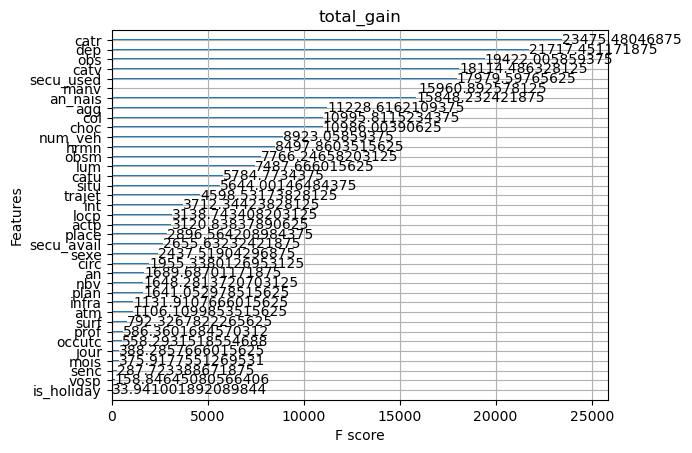

<Figure size 1600x1200 with 0 Axes>

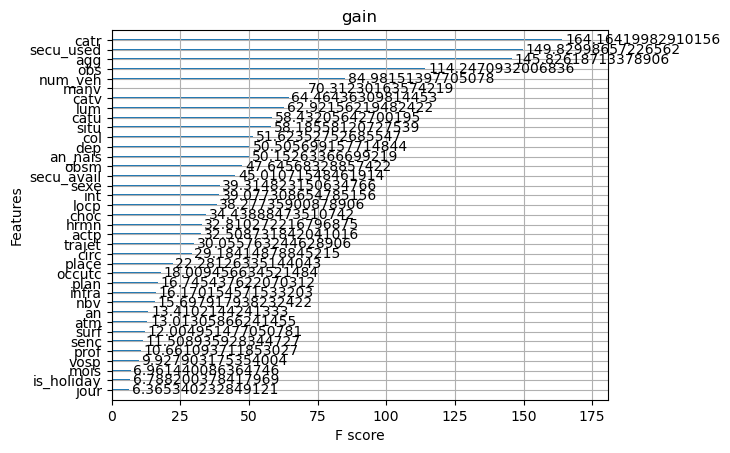

<Figure size 1600x1200 with 0 Axes>

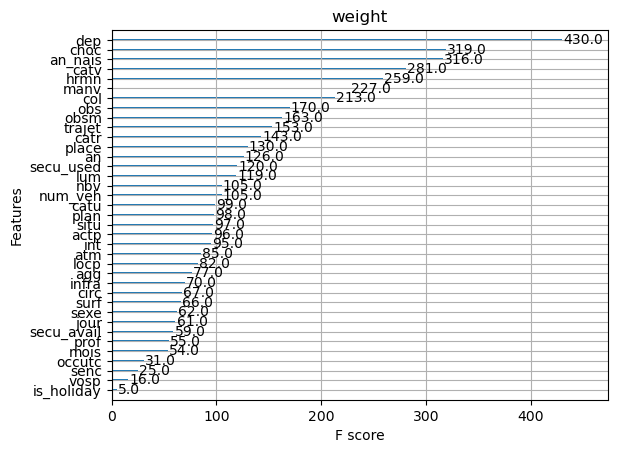

<Figure size 1600x1200 with 0 Axes>

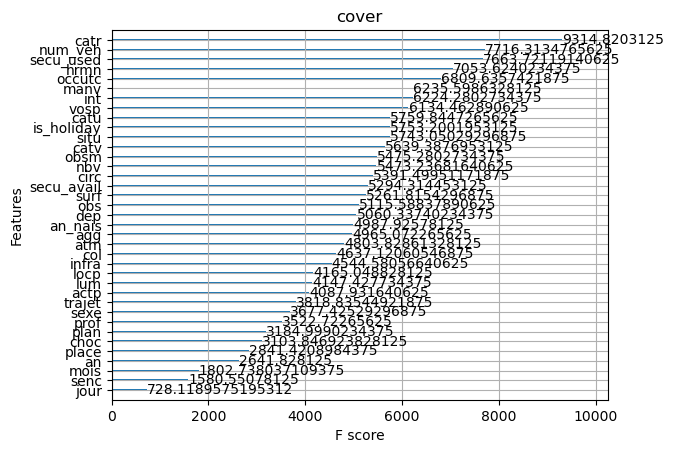

<Figure size 1600x1200 with 0 Axes>

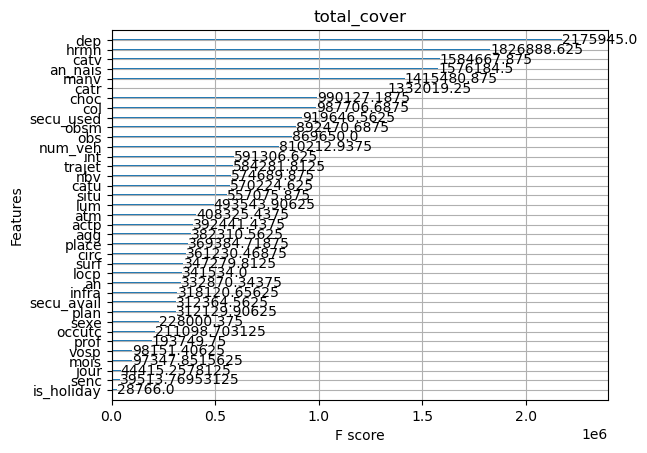

<Figure size 1600x1200 with 0 Axes>

In [34]:
importance_types = ['total_gain', 'gain', 'weight', 'cover', 'total_cover']

for f in importance_types:
    xgb.plot_importance(xgb_1, max_num_features=50, importance_type=f, title=f)
    plt.figure(figsize = (16, 12))
    plt.show();

In [ ]:
y_pred = xgb_1.predict(X_test)
y_pred = [round(value) for value in y_pred]

print(classification_report(y_pred, y_test))

print(pd.crosstab(y_pred, y_test))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5, 4))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True);

### Refining the model
The first modelling obviously does not correctly predict the `fatal`target, especially in case of `1`.

As next trial, the number of variables is reduced. Based on the `gain`importance, the 25% lowest variables are dropped.

In [97]:
# get the gain parameter result and estimate the variables to be dropped
gain = pd.Series(xgb_1.get_booster().get_score(importance_type = 'gain'))
drop_feature = gain[gain < gain.quantile(0.25)].index.to_list()

# an is required as grouping variable
drop_feature.remove('an')
drop_feature

['mois', 'jour', 'atm', 'vosp', 'prof', 'surf', 'senc', 'is_holiday']

In [98]:
# drop the features
df_encoded_if_1 = df_encoded.drop(drop_feature, axis = 1)
df_encoded_if_1.columns

Index(['an_nais', 'an', 'actp', 'num_veh', 'hrmn', 'place', 'catu', 'sexe',
       'trajet', 'locp', 'lum', 'agg', 'int', 'col', 'dep', 'catr', 'circ',
       'nbv', 'plan', 'infra', 'situ', 'catv', 'occutc', 'obs', 'obsm', 'choc',
       'manv', 'secu_used', 'secu_avail', 'fatal'],
      dtype='object')

In [99]:
# refine the dataset
X_train = df_encoded_if_1.loc[df_encoded_if_1['an'] < 2020].drop('fatal', axis = 1)
X_test = df_encoded_if_1.loc[df_encoded_if_1['an'] > 2019].drop('fatal', axis = 1)

y_train = df_encoded_if_1['fatal'].loc[df_encoded_if_1['an'] < 2020]
y_test = df_encoded_if_1['fatal'].loc[df_encoded_if_1['an'] > 2019]

In [101]:
# Running the crossvalidation or load stored parameters

# Rerun or get stored parameters
cv_rerun = True

# define the stored files
# gbtree
if (tuning_space['eval_metric'] == 'auc') and (tuning_space['booster'] == 'gbtree'):
    out_file_trial = './data/XGboost_model/160923_XGboost_gbtree_auc_trial_db_retuned'
    out_file_params = './data/XGboost_model/160923_XGboost_gbtree_auc_hyperparameters_retuned'
    
elif (tuning_space['eval_metric'] == 'lossless') and (tuning_space['booster'] == 'gbtree'):
    out_file_trial = './data/XGboost_model/160923_XGboost_gbtree_lossless_trial_db_retuned'
    out_file_params = './data/XGboost_model/160923_XGboost_gbtree_lossles_hyperparameters_retuned'

# dart
elif (tuning_space['eval_metric'] == 'auc') and (tuning_space['booster'] == 'dart'):
    out_file_trial = './data/XGboost_model/160923_XGboost_dart_auc_trial_db_retunde'
    out_file_params = './data/XGboost_model/160923_XGboost_dart_auc_hyperparameters_retuned'

elif (tuning_space['eval_metric'] == 'lossless') and (tuning_space['booster'] == 'dart'):
    out_file_trial = './data/XGboost_model/160923_XGboost_dart_lossless_trial_db_retuned'
    out_file_params = './data/XGboost_model/160923_XGboost_dart_lossles_hyperparameters_retuned'


# rerun the crossvalidation
if (cv_rerun == True):
    trials = Trials()
    best_hyperparams = fmin(fn = hp_xgbclass,
                       space = tuning_space,
                       algo = tpe.suggest,
                       max_evals = 100,
                       trials = trials)
    # save the best parameters and the trials database
    with open(out_file_trial, 'wb') as f:
        pickle.dump(trials, f)

    with open(out_file_params, 'wb') as f:
        pickle.dump(best_hyperparams, f)

# get the stored hyperparameters
else:
    with open('./data/XGboost_model/160923_XGboost_gbtree_auc_hyperparameters_retuned', 'rb') as f:
        best_hyperparams = pickle.load(f)

SCORE:                                                                                                                                                                                        
0.9749666689264005                                                                                                                                                                            
SCORE:                                                                                                                                                                                        
0.9746051115178632                                                                                                                                                                            
SCORE:                                                                                                                                                                                        
0.9749711883940072                           

In [103]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bylevel': 0.27090202086878545, 'colsample_bynode': 0.7311418235111645, 'colsample_bytree': 0.7414213910964151, 'eta': 0.49388178807236216, 'gamma': 2.7322961499367078, 'max_delta_step': 0.7304394613202749, 'max_depth': 7.0, 'min_child_weight': 7.0, 'n_estimators': 269.0, 'reg_alpha': 41.691349362938084, 'reg_lambda': 1.3035222273422526, 'scale_pos_weight': 0.8797228461174196, 'subsample': 0.9051950575029037}


In [104]:
if (tuning_space['booster'] == "gbtree"):
     xgb_2 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        enable_categorical = True
        
    )


if (tuning_space['booster'] == "dart"):
     xgb_2 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        rate_drop = best_hyperparams['rate_drop'],
        one_drop = space['one_drop'],
        skip_drop = best_hyperparams['skip_drop'],
        enable_categorical = True
    )
  
xgb_2 = xgb_2.fit(X_train,
          y_train,
          eval_set = [(X_test, y_test)], 
          verbose = False)

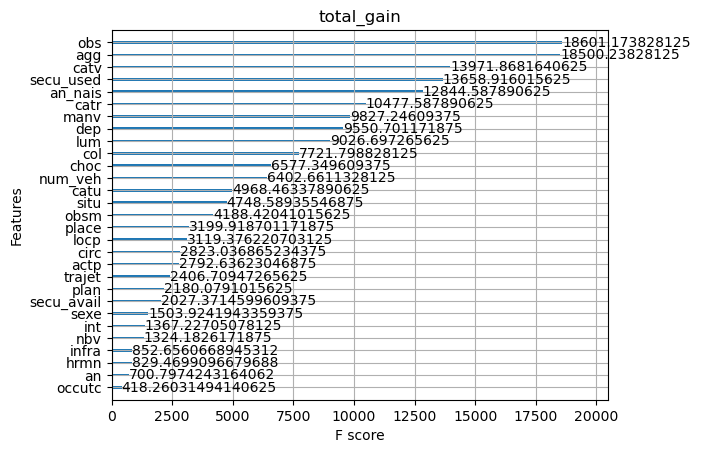

<Figure size 1600x1200 with 0 Axes>

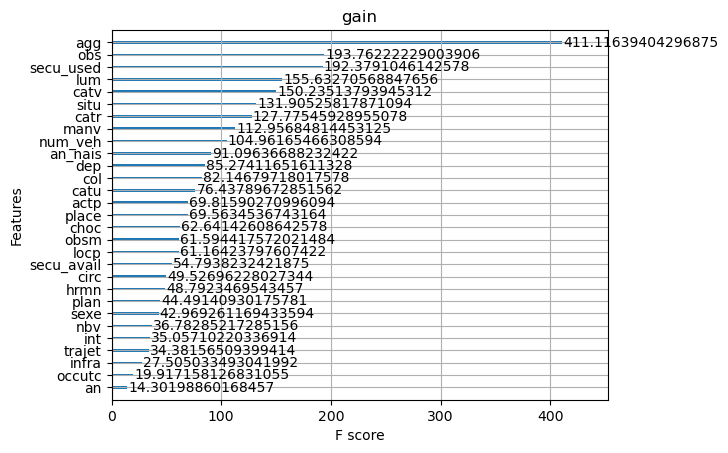

<Figure size 1600x1200 with 0 Axes>

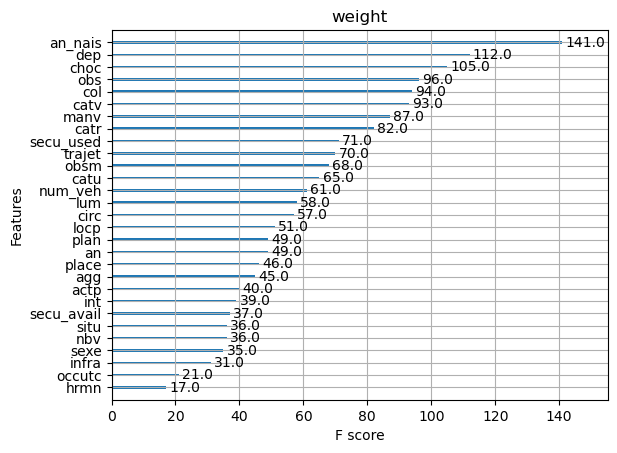

<Figure size 1600x1200 with 0 Axes>

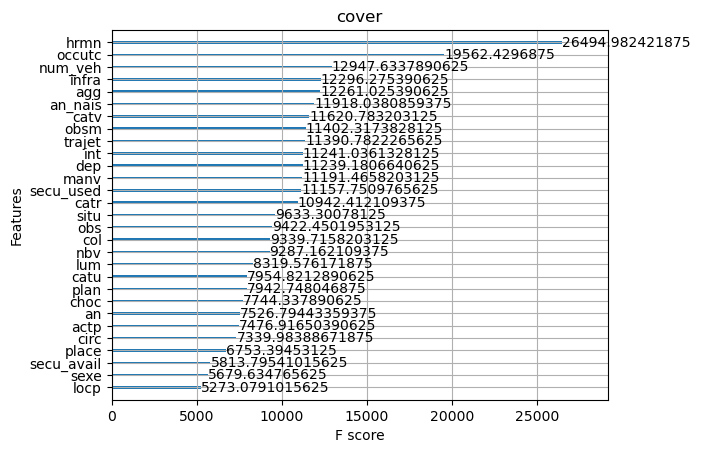

<Figure size 1600x1200 with 0 Axes>

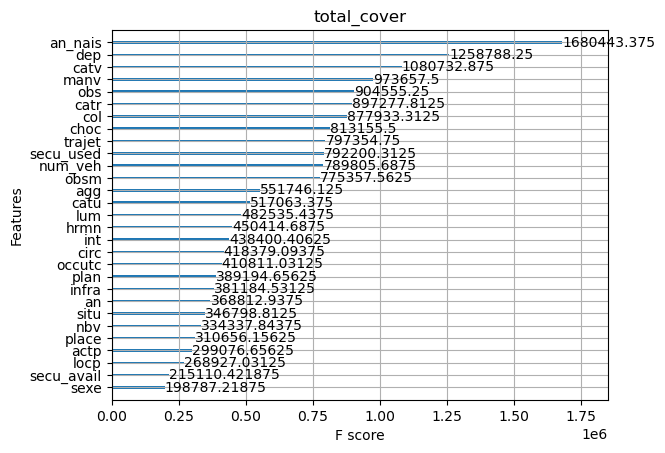

<Figure size 1600x1200 with 0 Axes>

In [105]:
importance_types = ['total_gain', 'gain', 'weight', 'cover', 'total_cover']

for f in importance_types:
    xgb.plot_importance(xgb_2, max_num_features=50, importance_type=f, title=f)
    plt.figure(figsize = (16, 12))
    plt.show();

In [106]:
y_pred = xgb_2.predict(X_test)
y_pred = [round(value) for value in y_pred]

print(classification_report(y_pred, y_test))

print(pd.crosstab(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    221096
           1       0.02      0.60      0.04       169

    accuracy                           0.98    221265
   macro avg       0.51      0.79      0.51    221265
weighted avg       1.00      0.98      0.99    221265

fatal       0     1
row_0              
0      215659  5437
1          67   102


In [108]:
# get the gain parameter result and estimate the variables to be dropped
gain = pd.Series(xgb_2.get_booster().get_score(importance_type = 'gain'))
drop_feature = gain[gain < gain.quantile(0.50)].index.to_list()

# an is required as grouping variable
drop_feature.remove('an')
drop_feature

['hrmn',
 'sexe',
 'trajet',
 'locp',
 'int',
 'circ',
 'nbv',
 'plan',
 'infra',
 'occutc',
 'obsm',
 'choc',
 'secu_avail']

In [110]:
# drop the features
df_encoded_if_2 = df_encoded_if_1.drop(drop_feature, axis = 1)
df_encoded_if_2.columns

Index(['an_nais', 'an', 'actp', 'num_veh', 'place', 'catu', 'lum', 'agg',
       'col', 'dep', 'catr', 'situ', 'catv', 'obs', 'manv', 'secu_used',
       'fatal'],
      dtype='object')

In [111]:
# refine the dataset
X_train = df_encoded_if_2.loc[df_encoded_if_2['an'] < 2020].drop('fatal', axis = 1)
X_test = df_encoded_if_2.loc[df_encoded_if_2['an'] > 2019].drop('fatal', axis = 1)

y_train = df_encoded_if_2['fatal'].loc[df_encoded_if_2['an'] < 2020]
y_test = df_encoded_if_2['fatal'].loc[df_encoded_if_2['an'] > 2019]

In [112]:
# Running the crossvalidation or load stored parameters

# Rerun or get stored parameters
cv_rerun = True

# define the stored files
# gbtree
if (tuning_space['eval_metric'] == 'auc') and (tuning_space['booster'] == 'gbtree'):
    out_file_trial = './data/XGboost_model/160923_XGboost_gbtree_auc_trial_db_retuned_2'
    out_file_params = './data/XGboost_model/160923_XGboost_gbtree_auc_hyperparameters_retuned_2'
    
elif (tuning_space['eval_metric'] == 'lossless') and (tuning_space['booster'] == 'gbtree'):
    out_file_trial = './data/XGboost_model/160923_XGboost_gbtree_lossless_trial_db_retuned_2'
    out_file_params = './data/XGboost_model/160923_XGboost_gbtree_lossles_hyperparameters_retuned_2'

# dart
elif (tuning_space['eval_metric'] == 'auc') and (tuning_space['booster'] == 'dart'):
    out_file_trial = './data/XGboost_model/160923_XGboost_dart_auc_trial_db_retunded_2'
    out_file_params = './data/XGboost_model/160923_XGboost_dart_auc_hyperparameters_retuned_2'

elif (tuning_space['eval_metric'] == 'lossless') and (tuning_space['booster'] == 'dart'):
    out_file_trial = './data/XGboost_model/160923_XGboost_dart_lossless_trial_db_retuned_2'
    out_file_params = './data/XGboost_model/160923_XGboost_dart_lossles_hyperparameters_retuned_2'


# rerun the crossvalidation
if (cv_rerun == True):
    trials = Trials()
    best_hyperparams = fmin(fn = hp_xgbclass,
                       space = tuning_space,
                       algo = tpe.suggest,
                       max_evals = 100,
                       trials = trials)
    # save the best parameters and the trials database
    with open(out_file_trial, 'wb') as f:
        pickle.dump(trials, f)

    with open(out_file_params, 'wb') as f:
        pickle.dump(best_hyperparams, f)

# get the stored hyperparameters
else:
    with open('./data/XGboost_model/160923_XGboost_gbtree_auc_hyperparameters_retuned__2', 'rb') as f:
        best_hyperparams = pickle.load(f)

SCORE:                                                                                                                                                                                        
0.9749802273292206                                                                                                                                                                            
SCORE:                                                                                                                                                                                        
0.9742119178360789                                                                                                                                                                            
SCORE:                                                                                                                                                                                        
0.9750977334869952                           

In [117]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bylevel': 0.7555419421108288, 'colsample_bynode': 0.3702180781428657, 'colsample_bytree': 0.3136475837472386, 'eta': 0.2503535521675566, 'gamma': 0.6609708110679069, 'max_delta_step': 0.31477320501203665, 'max_depth': 6.0, 'min_child_weight': 4.0, 'n_estimators': 764.0, 'reg_alpha': 13.768015941899966, 'reg_lambda': 6.601903800093804, 'scale_pos_weight': 0.9032998917712034, 'subsample': 0.8053465802624371}


In [114]:
if (tuning_space['booster'] == "gbtree"):
     xgb_3 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        enable_categorical = True
        
    )


if (tuning_space['booster'] == "dart"):
     xgb_3 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        rate_drop = best_hyperparams['rate_drop'],
        one_drop = space['one_drop'],
        skip_drop = best_hyperparams['skip_drop'],
        enable_categorical = True
    )
  
xgb_3 = xgb_3.fit(X_train,
          y_train,
          eval_set = [(X_test, y_test)], 
          verbose = False)

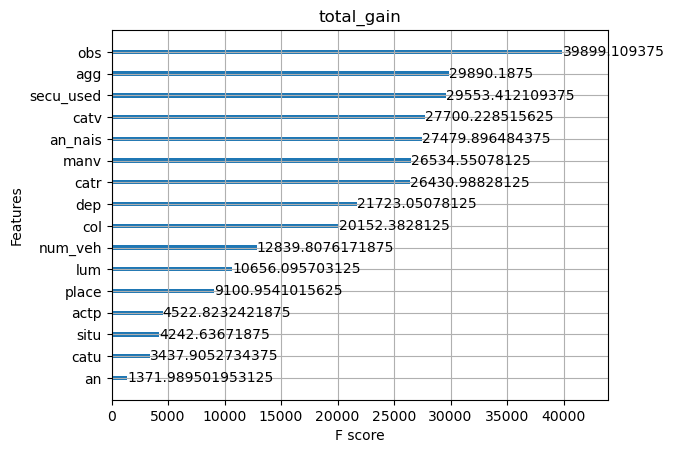

<Figure size 1600x1200 with 0 Axes>

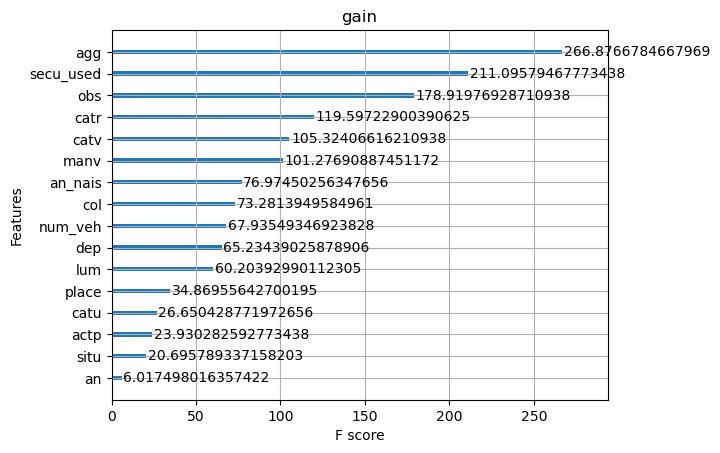

<Figure size 1600x1200 with 0 Axes>

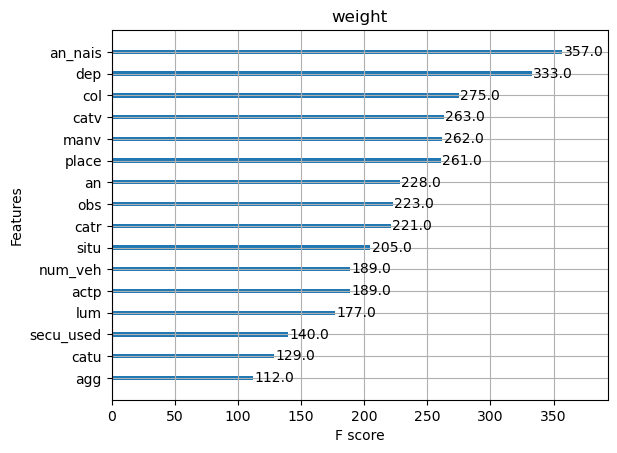

<Figure size 1600x1200 with 0 Axes>

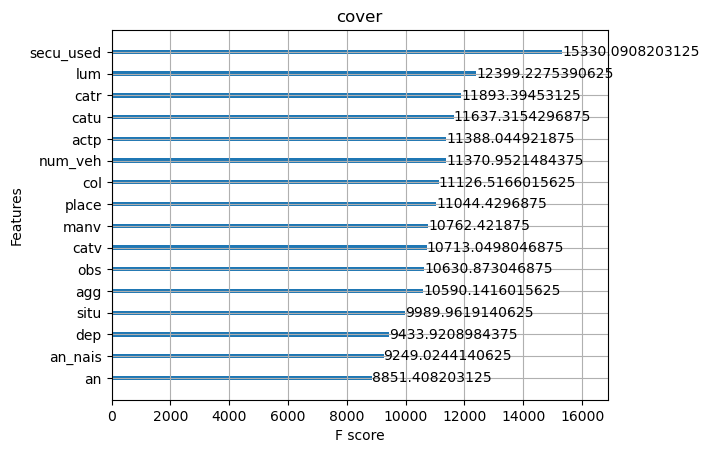

<Figure size 1600x1200 with 0 Axes>

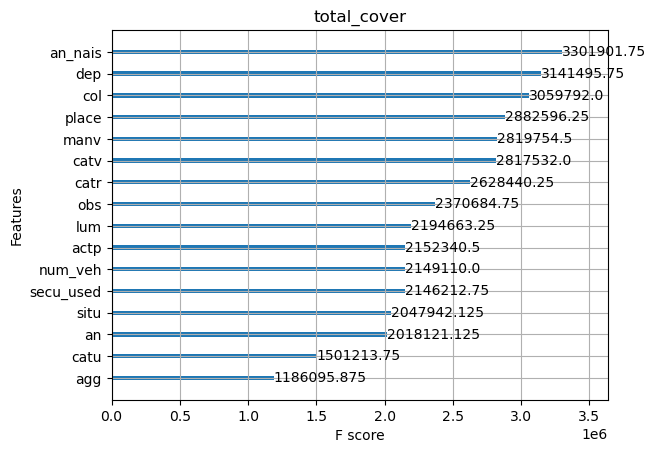

<Figure size 1600x1200 with 0 Axes>

In [115]:
importance_types = ['total_gain', 'gain', 'weight', 'cover', 'total_cover']
for f in importance_types:
    xgb.plot_importance(xgb_3, max_num_features=50, importance_type=f, title=f)
    plt.figure(figsize = (16, 12))
    plt.show();

In [116]:
y_pred = xgb_3.predict(X_test)
y_pred = [round(value) for value in y_pred]

print(classification_report(y_pred, y_test))

print(pd.crosstab(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    221213
           1       0.01      0.69      0.01        52

    accuracy                           0.98    221265
   macro avg       0.50      0.83      0.50    221265
weighted avg       1.00      0.98      0.99    221265

fatal       0     1
row_0              
0      215710  5503
1          16    36


## References
[1] [Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. TProc. of the 30th International Conference on Machine Learning (ICML 2013), June 2013, pp. I-115 to I-23.](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)

[2] https://towardsdatascience.com/hyperopt-demystified-3e14006eb6fa

[3] https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

[4] https://github.com/hyperopt/hyperopt

[5] https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

[6] https://github.com/hyperopt/hyperopt/wiki/FMin

[7] https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

[8] https://www.datamachines.io/blog/auc-vs-log-loss

[9] [Rashmi, K.V., Gilad-Bachrach (2015) DART: Dropouts meet Multiple Additive Regression Trees. arXiv:1505.01866v](https://doi.org/10.48550/arXiv.1505.01866)